## Setup

In [1]:
# Import Dependencies.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import json

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# Fetch the data from the API.
listings_json = requests.get("http://127.0.0.1:5000/api/v1.0/listings").json()

# Examine the data.
print(json.dumps(listings_json[0], indent=4, sort_keys=True))

{
    "address": "17452 NE GLISAN ST #7, Portland OR 97230",
    "bathrooms": 2.0,
    "bedrooms": 2,
    "built": 1988,
    "city": "Portland",
    "county": "Multnomah",
    "elementary_school": "Hartley",
    "high_school": "Reynolds",
    "home_type": "Manufactured - Double Wide Manufact",
    "lot_size": null,
    "middle_school": "Reynolds",
    "neighborhood": "unknown",
    "price": 72000,
    "square_feet": 1152,
    "zipcode": 97230
}


In [3]:
# Create a dataframe to use for our model.
data_df = pd.DataFrame(listings_json)

print(len(data_df))
data_df.head()

1822


,address,bathrooms,bedrooms,built,city,county,elementary_school,high_school,home_type,lot_size,middle_school,neighborhood,price,square_feet,zipcode
0,"17452 NE GLISAN ST #7, Portland OR 97230",2.0,2,1988,Portland,Multnomah,Hartley,Reynolds,Manufactured - Double Wide Manufact,NaN,Reynolds,unknown,72000,1152,97230
1,"16000 SE POWELL BLVD 75, Portland OR 97236",2.0,3,1990,Portland,Multnomah,Powell Butte,Centennial,Manufactured - Double Wide Manufact,NaN,Centennial,unknown,79950,1404,97236
2,"12846 SE RAMONA ST 6, Portland OR 97236",2.0,3,1997,Portland,Multnomah,Gilbert Hts,David Douglas,Manufactured - Double Wide Manufact,NaN,Alice Ott,unknown,93900,1297,97236
3,"7720 S Macadam AVE 7, Portland OR 97219",3.0,3,1988,Portland,Multnomah,Other,Other,Floating Home - Contemporary,NaN,Other,unknown,125000,2432,97219
4,"19609 NE Marine DR E-4, Portland OR 97230",1.0,1,1960,Portland,Multnomah,Salish Pond,Reynolds,Floating Home - Cabin,NaN,Reynolds,unknown,129500,735,97230


## Data Preprocessing

In [4]:
# Make a copy of the original data frame to modify.
model_df = data_df

# Insert a lot value of 0 for condos and floating homes.
for index, row in model_df.iterrows():
    if ("Condo" in row["home_type"]) | ("Floating" in row["home_type"]):
        model_df.loc[index, "lot_size"] = 0
    else:
        pass

# Include only those columns that will be used in the deep learning model.
model_df = model_df.loc[:, ["bathrooms", "bedrooms", "built", "lot_size", "square_feet", "price"]]
# Drop rows with NaN entries.
model_df.dropna(inplace=True)

# Check the model data.
print(len(model_df))
model_df.head()

1725


,bathrooms,bedrooms,built,lot_size,square_feet,price
3,3.0,3,1988,0.0,2432,125000
4,1.0,1,1960,0.0,735,129500
5,1.0,1,1974,0.0,720,141900
6,1.0,1,1927,0.0,382,144900
7,1.0,1,2004,0.0,513,149900


In [6]:
# Assign X (input) and y (target).

X = model_df.drop("price", axis=1)
y = model_df.loc[:,"price"].values.reshape(-1, 1)

In [7]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Create a MinMaxScaler model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [9]:
# Transform the training and testing data using the X_scaler and y_scaler models.

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Model Creation, Training, and Testing

In [15]:
# Create an mlp model.
model = MLPRegressor(hidden_layer_sizes=(100,100), random_state=42, max_iter=1000)

In [16]:
# Use grid search to tune the model.
grid = GridSearchCV(model, {"alpha":10.0 ** -np.arange(1, 7)}, verbose=2)
grid.fit(X_train_scaled, np.ravel(y_train_scaled))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ alpha=0.1, total=   2.2s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ........................................ alpha=0.1, total=   2.4s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   1.6s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   2.8s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   2.3s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   3.1s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   2.5s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   1.8s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100, 100),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=1000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=42, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha

In [17]:
# List the best parameters and best score.
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.1}
0.5926499312749705


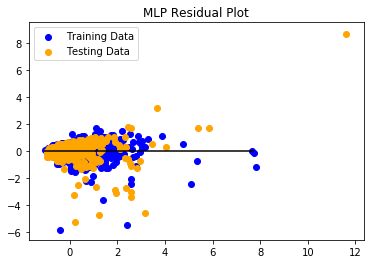

In [18]:
# Make predictions using a fitted MLPRegression model.
# Plot the difference between the model predicted values and actual y values, versus the model predicted values.

plt.scatter(grid.predict(X_train_scaled), grid.predict(X_train_scaled) - np.ravel(y_train_scaled), c="blue", label="Training Data")
plt.scatter(grid.predict(X_test_scaled), grid.predict(X_test_scaled) - np.ravel(y_test_scaled), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("MLP Residual Plot")
plt.show()

In [19]:
# Used X_test_scaled, y_test_scaled, and grid.predict(X_test_scaled) to calculate MSE and R2.

grid_predictions = grid.predict(X_test_scaled)
grid_MSE = mean_squared_error(y_test_scaled, grid_predictions)
grid_r2 = grid.score(X_test_scaled, y_test_scaled)

print(f"MSE: {grid_MSE}, R2: {grid_r2}")

MSE: 0.7134166347557871, R2: 0.5068216284144273
